In [11]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import (
    ChatPromptTemplate,
)
from langchain_experimental.utilities import PythonREPL
from langchain_openai import ChatOpenAI
import pandas as pd 
import json
import numpy as np

In [12]:

df = pd.read_html('./players_Big 5 European Leagues Combined_2324_standard.html')
df = df[0]
df.head()
df.reset_index(inplace=True)
df.columns = df.columns.droplevel(0)
new_columns = ['', 'Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born',
    'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK',
    'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC',
    'PrgP', 'PrgR', 'Gls/90', 'Ast/90', 'G+A/90', 'G-PK/90', 'G+A-PK/90', 'xG/90', 'xAG/90',
    'xG+xAG/90', 'npxG/90', 'npxG+xAG/90', 'Matches']
df.to_csv('players_Big 5 European Leagues Combined_2324_standard.csv', index=False)

df.columns = new_columns

df['Age'] = df['Age'].str[:2]
df['Age'] =pd.to_numeric(df['Age'], errors='coerce')
df['90s'] =pd.to_numeric(df['90s'], errors='coerce')
columns_to_convert = ['MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK',
                      'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC',
                      'PrgP', 'PrgR', 'Gls/90', 'Ast/90', 'G+A/90', 'G-PK/90', 'G+A-PK/90',
                      'xG/90', 'xAG/90', 'xG+xAG/90', 'npxG/90', 'npxG+xAG/90','Matches']

df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
df.MP = pd.to_numeric(df.MP, errors='coerce')   


In [15]:
from mplsoccer import Radar, FontManager, grid
import matplotlib.pyplot as plt

# parameter names of the statistics we want to show

URL1 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-Regular.ttf')
serif_regular = FontManager(URL1)
URL2 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-ExtraLight.ttf')
serif_extra_light = FontManager(URL2)
URL3 = ('https://raw.githubusercontent.com/google/fonts/main/ofl/rubikmonoone/'
        'RubikMonoOne-Regular.ttf')
rubik_regular = FontManager(URL3)
URL4 = 'https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Thin.ttf'
robotto_thin = FontManager(URL4)
URL5 = ('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
        'RobotoSlab%5Bwght%5D.ttf')
robotto_bold = FontManager(URL5)

def plot_radar(player_values_tuple):
    player1, player2 = player_values_tuple
   
    # Extract parameters
    params_chosen = list(player1.keys())[3:]
    player2_values = df[df.Player == player2['Player']][params_chosen].values.tolist()[0]
    player1_values = df[df.Player == player1['Player']][params_chosen].values.tolist()[0]
    
    # Calculate low and high values
    #low = [df[i].quantile(0.05) for i in df[params_chosen]]
    #high = [df[i].quantile(1) for i in df[params_chosen]]
    
    low = [df[i].quantile(0.05) + df.loc[df['MP'] > 5, i].values[0] for i in params_chosen]
    high = [df[i].quantile(.95) + df.loc[df['MP'] > 5, i].values[0] for i in params_chosen]
    # Radar setup
    radar = Radar(params_chosen, low, high,
                  round_int=[False]*len(params_chosen),
                  num_rings=4, ring_width=1, center_circle_radius=1)
    
    # Plot radar
    fig, ax = radar.setup_axis()

    # Rings
    rings_inner = radar.draw_circles(ax=ax, facecolor='#e6e6e6', edgecolor='#666666')

    # Radar plot
    radar_output = radar.draw_radar_compare(player1_values, player2_values, ax=ax,
                                            kwargs_radar={'facecolor': '#00a8e6', 'alpha': 0.7},
                                            kwargs_compare={'facecolor': '#e6bbff', 'alpha': 0.8})
    radar_poly, radar_poly2, vertices1, vertices2 = radar_output

    # Labels
    range_labels = radar.draw_range_labels(ax=ax, fontsize=15, fontproperties=robotto_thin.prop)
    param_labels = radar.draw_param_labels(ax=ax, fontsize=15, fontproperties=robotto_thin.prop)

    # Legend
    legend = ax.legend([radar_poly, radar_poly2], [player1['Player'], player2['Player']],
                       loc=(0.9, .90), fontsize=25, frameon=True, prop=robotto_thin.prop)
    # legend.get_frame().set_facecolor('#e6e6e6')  # Light gray legend background
    legend.get_frame().set_edgecolor('#aaaaff66')  # Gray legend edge color

    plt.show()





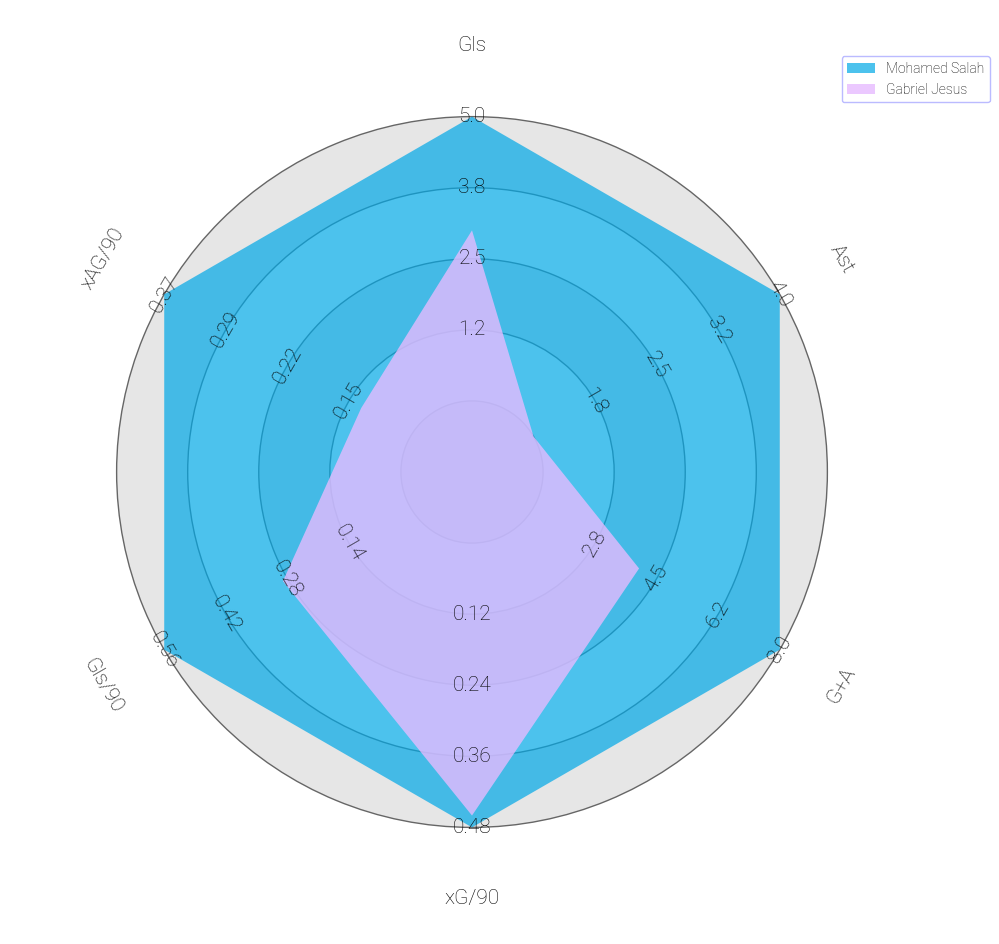

In [17]:
template = """
you help query a database and as such must always return python code!!  that can be executed to get the answer to the question.
a list of column names which correspond to football facts are listed ['MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK',
       'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC',
       'PrgP', 'PrgR', 'Gls/90', 'Ast/90', 'G+A/90', 'G-PK/90', 'G+A-PK/90', 'xG/90', 'xAG/90',
       'xG+xAG/90', 'npxG/90', 'npxG+xAG/90' ]  


       
       example
        questions: "top goal scorer in la liga"
        you :df[df['Comp'] == 'es La Liga'][['Player', 'Squad','Comp', 'Gls', 'MP', 'Nation', 'Age']].sort_values(by='Gls', ascending=False).head(1).to_json(orient='records')

        questions = "players with most xg in the epl "
        you:df[df['Comp'] == 'eng Premier League'][['Player','Squad', 'Comp', 'xG', 'MP', 'Nation', 'Age']].sort_values(by='xG', ascending=False).head(10).to_json(orient='records')

        questions = "compare the best player in la liga with the best player in the epl"
        you: params = list(df.columns[3:]) 
get_player = lambda player_name: json.loads(df[df['Player'] == player_name][['Player', 'Squad', 'Comp', 'Gls', 'Ast', 'G+A', 'xG/90', 'Gls/90', 'xAG/90']].head(1).to_json(orient='records'))[0]
player1, player2 = map(get_player, ['Bukayo Saka', 'Phil Foden'])
plot_radar((player1, player2))

         """
human_input = "{question}" 
chat_model = ChatOpenAI(temperature=0.2)
chat_prompt = ChatPromptTemplate.from_messages([("system", template), ("human", human_input)])
messages = chat_prompt.format_messages(question = "compare Salah  and Jesus,  on the basis of attacking stats ")
result = chat_model.predict_messages(messages)
insider = result.content
exec(insider,globals(), locals())


